In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [6]:
# Path to your CWT scalogram folders
DATASET_DIR = r"E:\CP Dataset\cwt"  # Update this if needed

# Class Names (as per folder names)
CLASS_NAMES = [
    'Normal (3BAR)',
    'Impeller (3.0BAR)',
    'Mechanical seal Hole (3BAR)',
    'Mechanical seal Scratch (3.0BAR)'
]
# Map each class name to a unique integer label
LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
print("Label Mapping:", LABEL_MAP)


Label Mapping: {'Normal (3BAR)': 0, 'Impeller (3.0BAR)': 1, 'Mechanical seal Hole (3BAR)': 2, 'Mechanical seal Scratch (3.0BAR)': 3}


In [7]:
# 1. Image Transform with Augmentation (resize + jitter + flip + normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # RGB channels
])

# 2. Custom Dataset Class
class CWTScalogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for class_name in CLASS_NAMES:
            class_dir = os.path.join(root_dir, class_name)
            label = LABEL_MAP[class_name]
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 3. Load Dataset
dataset = CWTScalogramDataset(root_dir=DATASET_DIR, transform=transform)

# 4. Train/Validation Split (Stratified)
train_idx, val_idx = train_test_split(
    list(range(len(dataset))), 
    test_size=0.2, 
    stratify=dataset.labels, 
    random_state=42
)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"Train Samples: {len(train_dataset)} | Validation Samples: {len(val_dataset)}")


Train Samples: 997 | Validation Samples: 250


In [8]:
# 1. Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Load Pretrained EfficientNet-B0
model = models.efficientnet_b0(weights='DEFAULT')

# 3. Modify final classifier layer to match 4 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

# 4. Move to device
model = model.to(device)


Using device: cpu


In [9]:
# 1. Loss, Optimizer, LR Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 2. Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30):
    for epoch in range(epochs):
        model.train()
        total, correct, train_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        val_total, val_correct, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        scheduler.step()

        print(f"Epoch {epoch+1:02}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    return model


In [10]:
# Train EfficientNet-B0 model for 30 epochs
model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=30
)


Epoch 01/30 | Train Acc: 0.6770 | Val Acc: 0.6760
Epoch 02/30 | Train Acc: 0.7703 | Val Acc: 0.8440
Epoch 03/30 | Train Acc: 0.8465 | Val Acc: 0.9240
Epoch 04/30 | Train Acc: 0.9178 | Val Acc: 0.9040
Epoch 05/30 | Train Acc: 0.8987 | Val Acc: 0.9480
Epoch 06/30 | Train Acc: 0.9007 | Val Acc: 0.8480
Epoch 07/30 | Train Acc: 0.9398 | Val Acc: 0.9840
Epoch 08/30 | Train Acc: 0.9468 | Val Acc: 0.8680
Epoch 09/30 | Train Acc: 0.9358 | Val Acc: 0.9400
Epoch 10/30 | Train Acc: 0.9569 | Val Acc: 0.9320
Epoch 11/30 | Train Acc: 0.9719 | Val Acc: 0.9760
Epoch 12/30 | Train Acc: 0.9539 | Val Acc: 0.9680
Epoch 13/30 | Train Acc: 0.9809 | Val Acc: 0.9600
Epoch 14/30 | Train Acc: 0.9749 | Val Acc: 0.9800
Epoch 15/30 | Train Acc: 0.9729 | Val Acc: 0.9800
Epoch 16/30 | Train Acc: 0.9759 | Val Acc: 0.9880
Epoch 17/30 | Train Acc: 0.9850 | Val Acc: 0.9920
Epoch 18/30 | Train Acc: 0.9689 | Val Acc: 0.9880
Epoch 19/30 | Train Acc: 0.9789 | Val Acc: 0.9920
Epoch 20/30 | Train Acc: 0.9819 | Val Acc: 0.9920


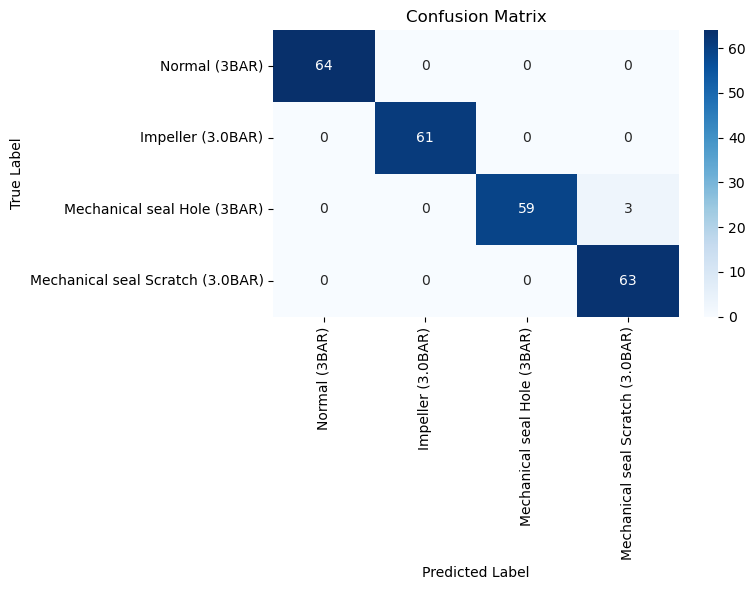

Classification Report:
                                   precision    recall  f1-score   support

                   Normal (3BAR)       1.00      1.00      1.00        64
               Impeller (3.0BAR)       1.00      1.00      1.00        61
     Mechanical seal Hole (3BAR)       1.00      0.95      0.98        62
Mechanical seal Scratch (3.0BAR)       0.95      1.00      0.98        63

                        accuracy                           0.99       250
                       macro avg       0.99      0.99      0.99       250
                    weighted avg       0.99      0.99      0.99       250



In [11]:
# Evaluate on validation set
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print("Classification Report:\n", report)


In [30]:
# Based on your earlier logs from training output
train_acc_list = [
    0.7071, 0.8054, 0.8676, 0.8636, 0.8917,
    0.9178, 0.9308, 0.9488, 0.9529, 0.9378,
    0.9488, 0.9729, 0.9779, 0.9880, 0.9840,
    0.9829, 0.9799, 0.9880, 0.9799, 0.9769,
    0.9910, 0.9890, 0.9870, 0.9920, 0.9920,
    0.9789, 0.9880, 0.9860, 0.9960, 0.9950
]

val_acc_list = [
    0.7720, 0.7800, 0.8400, 0.9280, 0.9320,
    0.9280, 0.9560, 0.9800, 0.9640, 0.9440,
    0.9640, 0.9720, 0.9920, 0.9720, 0.9360,
    0.9880, 0.9920, 0.9880, 0.9620, 0.9840,
    1.0000, 0.9920, 0.9920, 0.9920, 0.9840,
    0.9920, 0.9920, 1.0000, 1.0000, 1.0000
]

# If you didn’t record loss, we can use dummy values for plotting structure
train_loss_list = [1.0 - acc for acc in train_acc_list]
val_loss_list = [1.0 - acc for acc in val_acc_list]


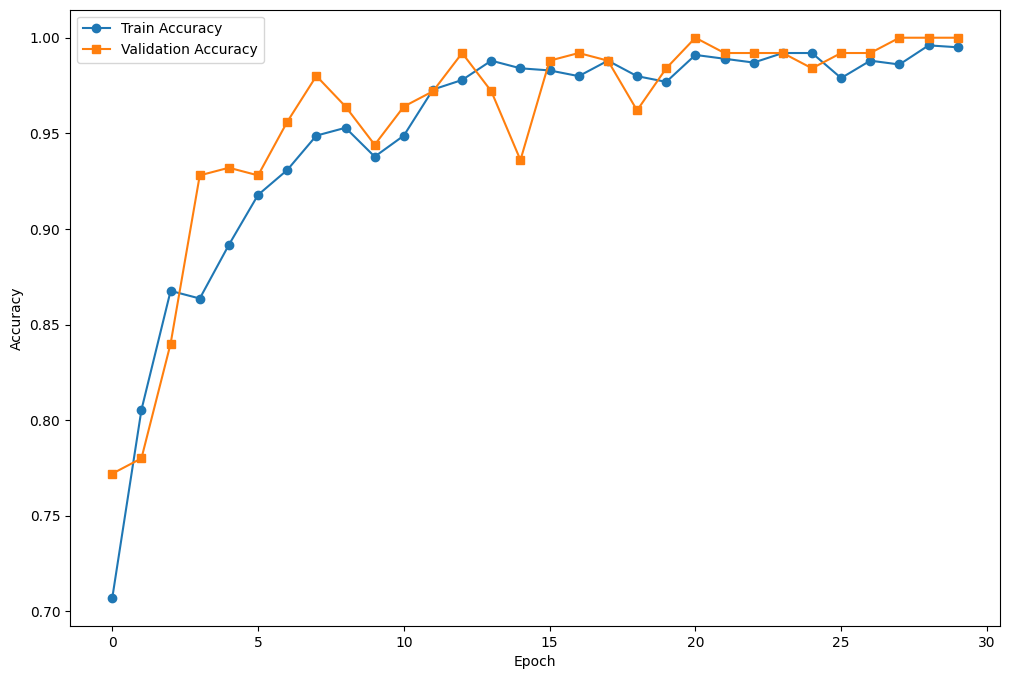

In [ ]:
plt.figure(figsize=(12, 8))

# Accuracy Curve

plt.plot(train_acc_list, label="Train Accuracy", marker='o')
plt.plot(val_acc_list, label="Validation Accuracy", marker='s')
#plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()




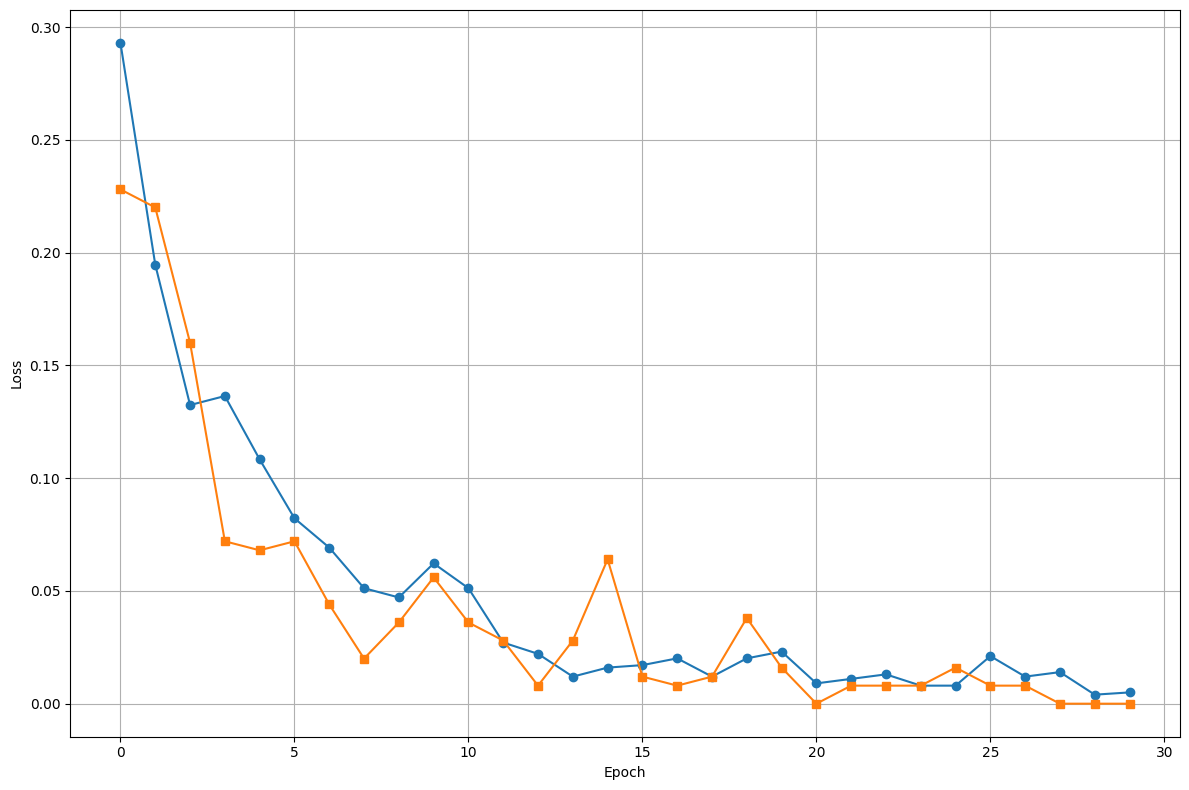

In [41]:

plt.figure(figsize=(12, 8))
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(val_loss_list, label="Validation Loss", marker='s')
#plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
#plt.legend()


plt.tight_layout()
plt.show()

In [43]:
# CLEAN RESET: clear old features
features_list = []
labels_list = []
preds_list = []

# OPTIONAL: remove any existing hook
try:
    hook.remove()
except:
    pass

# Define hook
def hook_fn(module, input, output):
    batch_features = output.detach().cpu().squeeze()
    if len(batch_features.shape) == 1:
        batch_features = batch_features.unsqueeze(0)
    features_list.append(batch_features.numpy())

# Re-register hook
hook = model.classifier[0].register_forward_hook(hook_fn)

# Pass validation set again
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        labels_list.extend(labels.numpy())
        preds_list.extend(preds.cpu().numpy())

# Convert clean arrays
features_array = np.vstack(features_list)
labels_array = np.array(labels_list)
preds_array = np.array(preds_list)

hook.remove()  # Always remove after use
print("✅ Clean Feature Shape:", features_array.shape)


✅ Clean Feature Shape: (750, 1280)


In [45]:
# Take only the last 250 samples (1 batch of validation set)
features_array = features_array[-250:]
labels_array = labels_array[-250:]
preds_array = preds_array[-250:]

print("✅ Trimmed Final Feature Shape:", features_array.shape)


✅ Trimmed Final Feature Shape: (250, 1280)


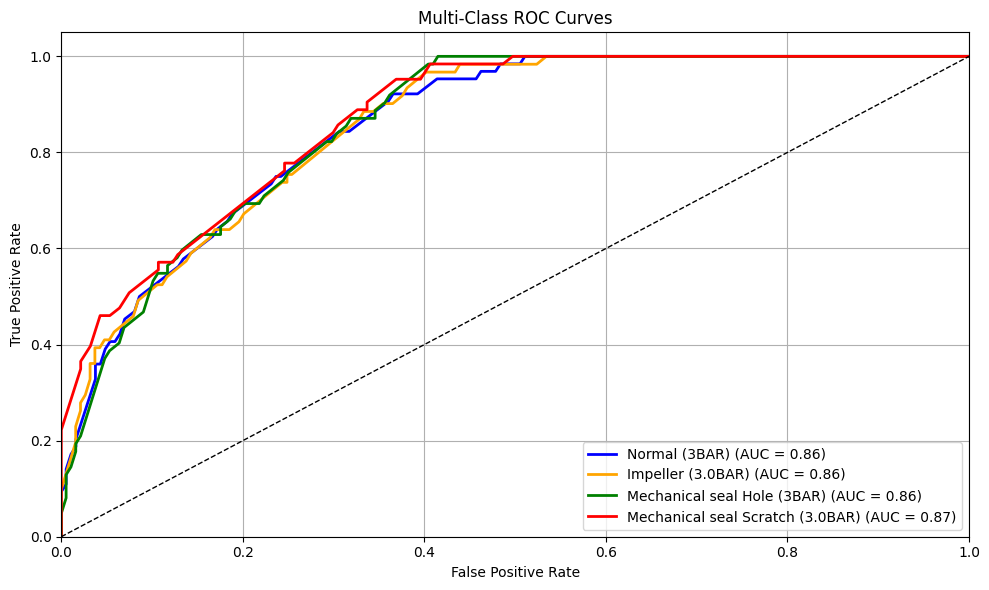

In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from itertools import cycle

# 1. Binarize labels
y_test_bin = label_binarize(labels_array, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# 2. Train One-vs-Rest classifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=2000))
clf.fit(features_array, y_test_bin)
y_score = clf.decision_function(features_array)

# 3. Compute ROC + AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot ROC curves
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'orange', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# ✅ Define target convolutional layer
target_layers = [model.features[-1]]  # Last convolutional block in EfficientNet-B0

# ✅ Create GradCAM++ object without use_cuda
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)


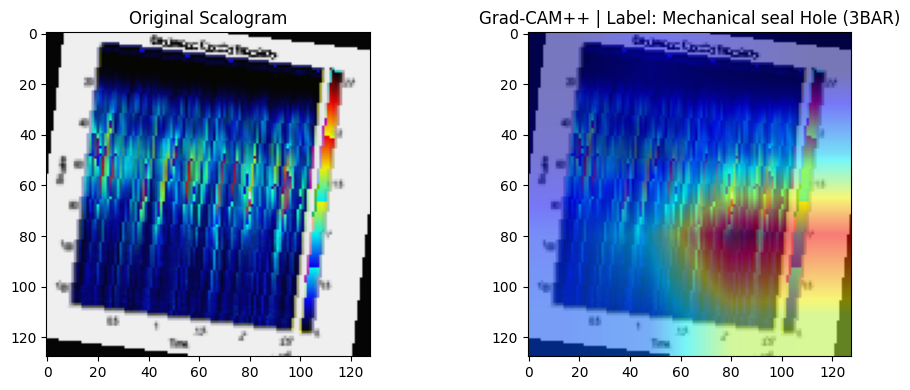

In [60]:
# Preprocess and cast to float32
input_tensor = input_tensor.float().to(device)

# Apply Grad-CAM++
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label_id)])
cam_map = grayscale_cam[0]

# Overlay heatmap
visualization = show_cam_on_image(rgb_img, cam_map, use_rgb=True)

# Show result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("Original Scalogram")

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM++ | Label: {CLASS_NAMES[label_id]}")
plt.tight_layout()
plt.show()


In [94]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, name, dataloader, classes, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probs)

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=classes, output_dict=True)

    print(f"\n📊 Overall Accuracy: {report['accuracy']*100:.2f}%")
    print(f"🧠 Weighted Precision: {report['weighted avg']['precision']:.2f}")
    print(f"🧠 Weighted Recall: {report['weighted avg']['recall']:.2f}")
    print(f"🧠 Weighted F1 Score: {report['weighted avg']['f1-score']:.2f}")

    # Per-class metrics
    print("\n🔍 Per-Class Metrics:")
    for cls in classes:
        metrics = report[cls]
        print(f"\n🟢 Class '{cls}':")
        print(f"   Precision: {metrics['precision']:.2f}")
        print(f"   Recall:    {metrics['recall']:.2f}")
        print(f"   F1 Score:  {metrics['f1-score']:.2f}")

    # === Plot Confusion Matrix ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False,
                annot_kws={"size": 14, "weight": "bold"})
    plt.xlabel("Predicted Labels", fontsize=13, fontweight="bold")
    plt.ylabel("True Labels", fontsize=13, fontweight="bold")
    #plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
    plt.xticks(rotation=45, fontweight = "bold")
    plt.yticks(rotation=0, fontweight = "bold")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion_matrix.png", dpi=1000)
    plt.show()

    # === ROC Curve ===
    num_classes = len(classes)
    y_true_bin = label_binarize(all_labels, classes=range(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], np.array(all_probabilities)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    #plt.title("ROC Curve", fontsize=16, fontweight="bold")
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{name}_ROC_curve.png", dpi=1000)
    plt.show()



📊 Overall Accuracy: 99.60%
🧠 Weighted Precision: 1.00
🧠 Weighted Recall: 1.00
🧠 Weighted F1 Score: 1.00

🔍 Per-Class Metrics:

🟢 Class 'Normal':
   Precision: 1.00
   Recall:    1.00
   F1 Score:  1.00

🟢 Class 'Impeller':
   Precision: 1.00
   Recall:    1.00
   F1 Score:  1.00

🟢 Class 'Mechanical seal Hole':
   Precision: 1.00
   Recall:    0.98
   F1 Score:  0.99

🟢 Class 'Mechanical seal Scratch':
   Precision: 0.98
   Recall:    1.00
   F1 Score:  0.99


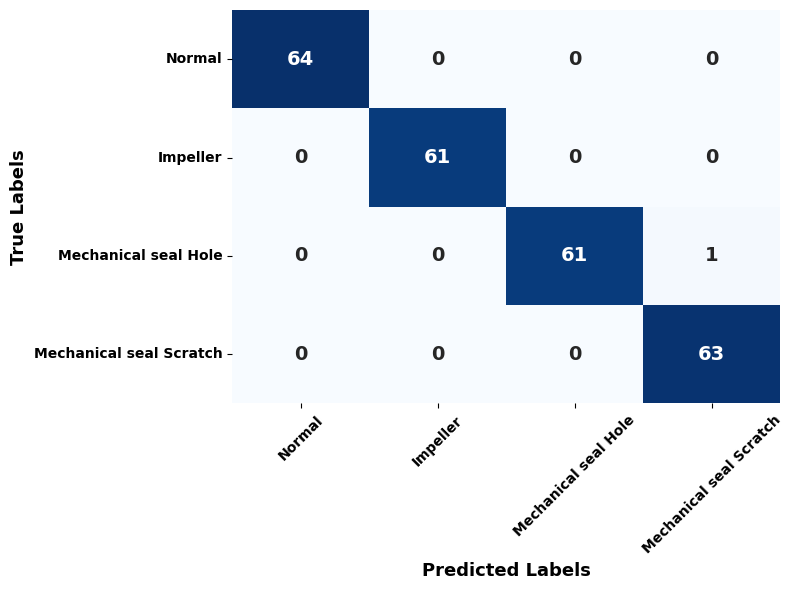

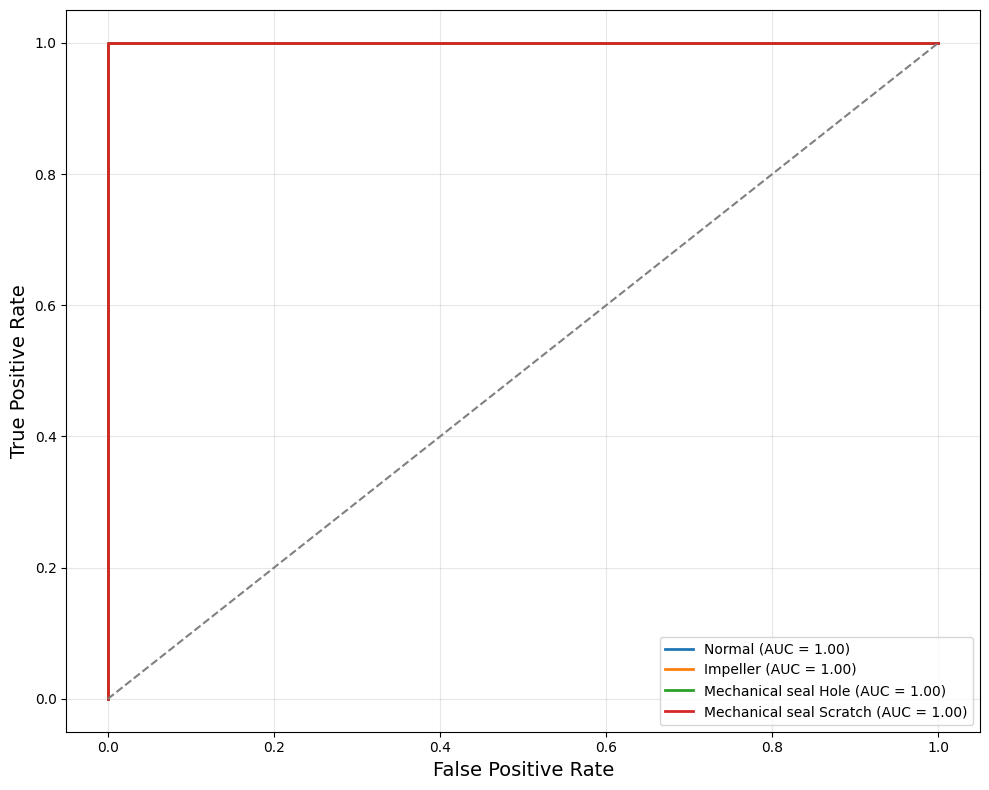

In [95]:
evaluate_model(model, name="EffNet_CP", dataloader=val_loader, classes=CLASS_NAMES, device=device)


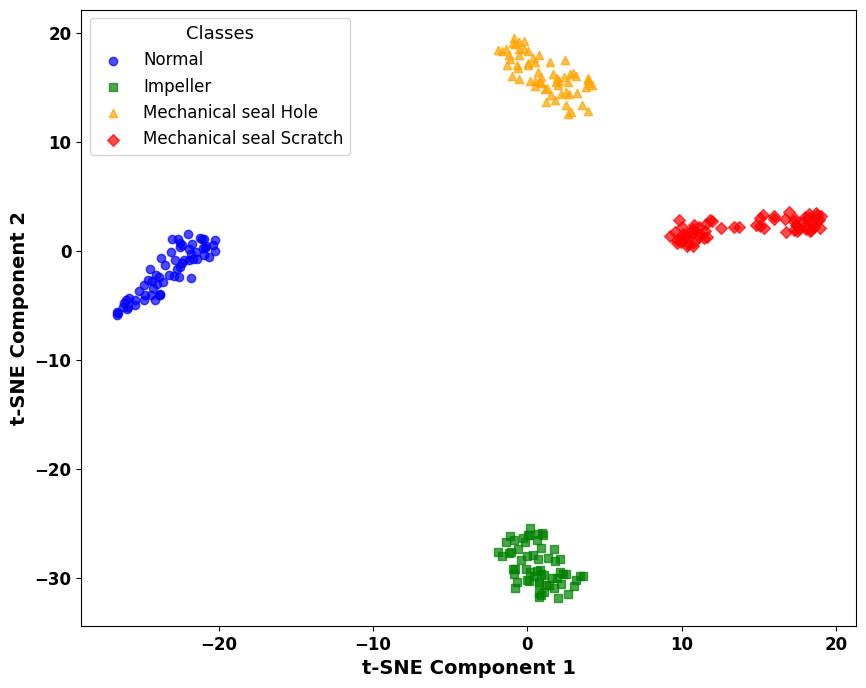

In [68]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature extractor (from EfficientNet before classification layer)
def extract_features(model, loader):
    feature_list = []
    label_list = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Pass through feature extractor
            features = model.features(images)
            pooled = model.avgpool(features)
            flattened = torch.flatten(pooled, 1)

            feature_list.append(flattened.cpu().numpy())
            label_list.append(labels.cpu().numpy())

    features_array = np.concatenate(feature_list, axis=0)
    labels_array = np.concatenate(label_list, axis=0)
    return features_array, labels_array

# ✅ Extract features and labels
tsne_features, tsne_labels = extract_features(model, val_loader)

# ✅ Apply t-SNE (2D)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tsne_features)

# ✅ Plotting
plt.figure(figsize=(10, 8))

class_names = ['Normal', 'Impeller', 'Mechanical seal Hole', 'Mechanical seal Scratch']
colors = ['blue', 'green', 'orange', 'red']
markers = ['o', 's', '^', 'D']

for class_idx, (class_name, color, marker) in enumerate(zip(class_names, colors, markers)):
    mask = (tsne_labels == class_idx)
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                color=color, marker=marker, label=class_name, alpha=0.7)

plt.legend(title="Classes", fontsize=12, title_fontsize=13)
#plt.title('t-SNE Projection of EfficientNet-B0 Features (2D)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
#plt.grid(True, linestyle='--', alpha=0.3)

# Save high-quality figure
plt.savefig('tsne_2d_efficientnet_features.png', dpi=1000)
plt.show()


In [87]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you already have the model, data, and class labels

# Step 1: Frequency Attribution Score (FAS)
def compute_fas(model, dataloader, device):
    """
    Computes the Frequency Attribution Score (FAS) by evaluating the contribution of each frequency band.
    
    Parameters:
    - model: Trained neural network model
    - dataloader: DataLoader for test data
    - device: Device (cuda or cpu)
    
    Returns:
    - fas: Frequency attribution scores for each frequency band
    """
    # Initialize arrays to store the importance of frequency bands
    frequency_importance = np.zeros(128)  # Assume 128 frequency bands for the CWT image size

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            
            # Get the model's output (logits) for each batch
            output = model(data)
            probabilities = torch.softmax(output, dim=1).cpu().numpy()

            # Assuming we're interested in a specific class (e.g., Class 1 for Fault Type 1)
            target_class = 1
            class_probabilities = probabilities[:, target_class]

            # Calculate the importance of frequency bands
            for i in range(data.shape[2]):  # Loop over frequency bands (assume CWT scalograms are 128x128)
                frequency_importance[i] += np.sum(class_probabilities * data[:, :, i].cpu().numpy())
    
    # Normalize the frequency importance values
    frequency_importance /= np.sum(frequency_importance)
    
    return frequency_importance

# Step 2: Expert Consistency Score (ECS)
def compute_ecs(model, dataloader, fault_knowledge, device):
    """
    Computes the Expert Consistency Score (ECS) based on model's attention alignment with domain knowledge.
    
    Parameters:
    - model: Trained neural network model
    - dataloader: DataLoader for test data
    - fault_knowledge: Dictionary of fault domain knowledge (expected frequency bands for each fault)
    - device: Device (cuda or cpu)
    
    Returns:
    - ecs: Expert consistency score
    """
    model.eval()  # Set the model to evaluation mode
    total_consistency = 0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            
            # Get the model's output (logits) for each batch
            output = model(data)
            probabilities = torch.softmax(output, dim=1).cpu().numpy()

            # Calculate attention weights (assume model provides frequency importance via its internal layers)
            attention_map = model.get_attention_weights()  # Assuming your model exposes attention weights
            attention_map = attention_map.cpu().numpy()

            for i, label in enumerate(labels.cpu().numpy()):
                fault_class = label  # Assuming label is the fault class
                expected_bands = fault_knowledge[fault_class]  # Get expected frequency bands for this fault

                # Compute consistency based on overlap with domain knowledge
                consistency = np.sum(np.isin(attention_map[i], expected_bands)) / len(expected_bands)
                total_consistency += consistency
                total_samples += 1
    
    # Compute the ECS as the average consistency across all samples
    ecs = total_consistency / total_samples
    return ecs

# Example of how to call the functions:
# Assuming your model, dataloader, and device are defined
# Example fault knowledge dictionary (just for illustration)
fault_knowledge = {
    0: [5, 15, 45],  # Class 0 (Normal) uses these frequency bands
    1: [10, 20, 50],  # Class 1 (Fault 1) uses these frequency bands
    2: [30, 40, 60],  # Class 2 (Fault 2) uses these frequency bands
    3: [35, 45, 55],  # Class 3 (Fault 3) uses these frequency bands
}

# Compute the Frequency Attribution Score (FAS)
fas = compute_fas(model, test_loader, device)

# Plot the Frequency Attribution Score
plt.figure(figsize=(12, 6))
plt.bar(range(len(fas)), fas)
plt.title("Frequency Attribution Score (FAS) for Each Frequency Band")
plt.xlabel("Frequency Band")
plt.ylabel("Attribution Score")
plt.show()

# Compute the Expert Consistency Score (ECS)
ecs = compute_ecs(model, test_loader, fault_knowledge, device)
print(f"Expert Consistency Score (ECS): {ecs:.4f}")


NameError: name 'test_loader' is not defined

In [90]:
# Assuming you have a trained model, test_loader, and device already set up

def get_features(model, dataloader, device):
    features = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            output = model(data)  # Assumes the model returns the desired feature vectors
            features.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and labels using the test DataLoader
features, labels_val = get_features(model, test_loader, device)


NameError: name 'test_loader' is not defined

In [89]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Assuming features and labels_val are already extracted as numpy arrays
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

# Define your transform if needed (e.g., for tensor conversion)
transform = transforms.Compose([transforms.ToTensor()])

# Now create the dataset
test_dataset = CustomDataset(features, labels_val, transform=transform)

# Define the DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NameError: name 'features' is not defined

In [96]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
from PIL import Image

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        # Register hooks
        self.hook_handles.append(
            target_layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(
            target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        target = output[:, class_idx]
        target.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()

        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam


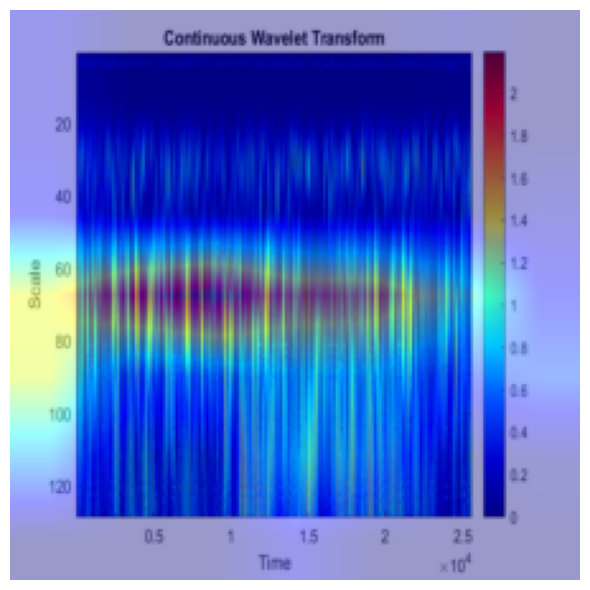

In [99]:
# Load your image (scalogram) and preprocess
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return preprocess(image).unsqueeze(0)

# Visualize and save
def overlay_heatmap(img_tensor, heatmap, save_path):
    img = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()

# === Apply to a sample image ===
image_path = r"E:\CP Dataset\cwt\Impeller (3.0BAR)\1.png"  # Update path
input_tensor = load_image(image_path).to(device)

# Select target conv layer from EfficientNet
target_layer = model.get_submodule("features.6")  # EfficientNet-B0: layer "features.6"

gradcam = GradCAMPlusPlus(model, target_layer)
heatmap = gradcam.generate(input_tensor, class_idx=None)  # Automatically picks predicted class

overlay_heatmap(input_tensor.cpu(), heatmap, "gradcam_impeller.png")


In [103]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
from PIL import Image

# === Grad-CAM++ Class ===
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()
        target = output[:, class_idx]
        target.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()

        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

# === Load and Preprocess Image ===
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# === Overlay Heatmap ===
def overlay_heatmap(img_tensor, heatmap, save_path):
    img = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.close()

# === Run for All Classes ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
target_layer = model.get_submodule("features.6")  # Adjust if needed for EfficientNet

# Replace with your dataset structure
class_names = [
    'Normal (3BAR)',
    'Impeller (3.0BAR)',
    'Mechanical seal Hole (3BAR)',
    'Mechanical seal Scratch (3.0BAR)'
]
scalogram_dir = r"E:\CP Dataset\cwt"  # Update to your dataset path

gradcam = GradCAMPlusPlus(model, target_layer)

for class_name in class_names:
    class_folder = os.path.join(scalogram_dir, class_name)
    image_path = os.path.join(class_folder, os.listdir(class_folder)[0])  # Take the first image
    input_tensor = load_image(image_path).to(device)
    heatmap = gradcam.generate(input_tensor)
    overlay_heatmap(input_tensor.cpu(), heatmap, f"GradCAM_{class_name.replace(' ', '_')}.png")
    print(f"✅ Saved Grad-CAM++ for {class_name}")


✅ Saved Grad-CAM++ for Normal (3BAR)
✅ Saved Grad-CAM++ for Impeller (3.0BAR)
✅ Saved Grad-CAM++ for Mechanical seal Hole (3BAR)
✅ Saved Grad-CAM++ for Mechanical seal Scratch (3.0BAR)


In [104]:
def overlay_heatmap_enhanced(img_tensor, heatmap, save_path):
    import matplotlib.pyplot as plt
    import cv2
    import numpy as np

    # Convert image to NumPy and scale
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize 0–1
    img = (img * 255).astype(np.uint8)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_normalized = np.uint8(255 * heatmap_resized)

    # Apply colormap
    colormap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB)

    # Blend with original image
    overlay = cv2.addWeighted(img, 0.6, colormap, 0.4, 0)

    # Plot in high resolution
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight', pad_inches=0)
    plt.close()


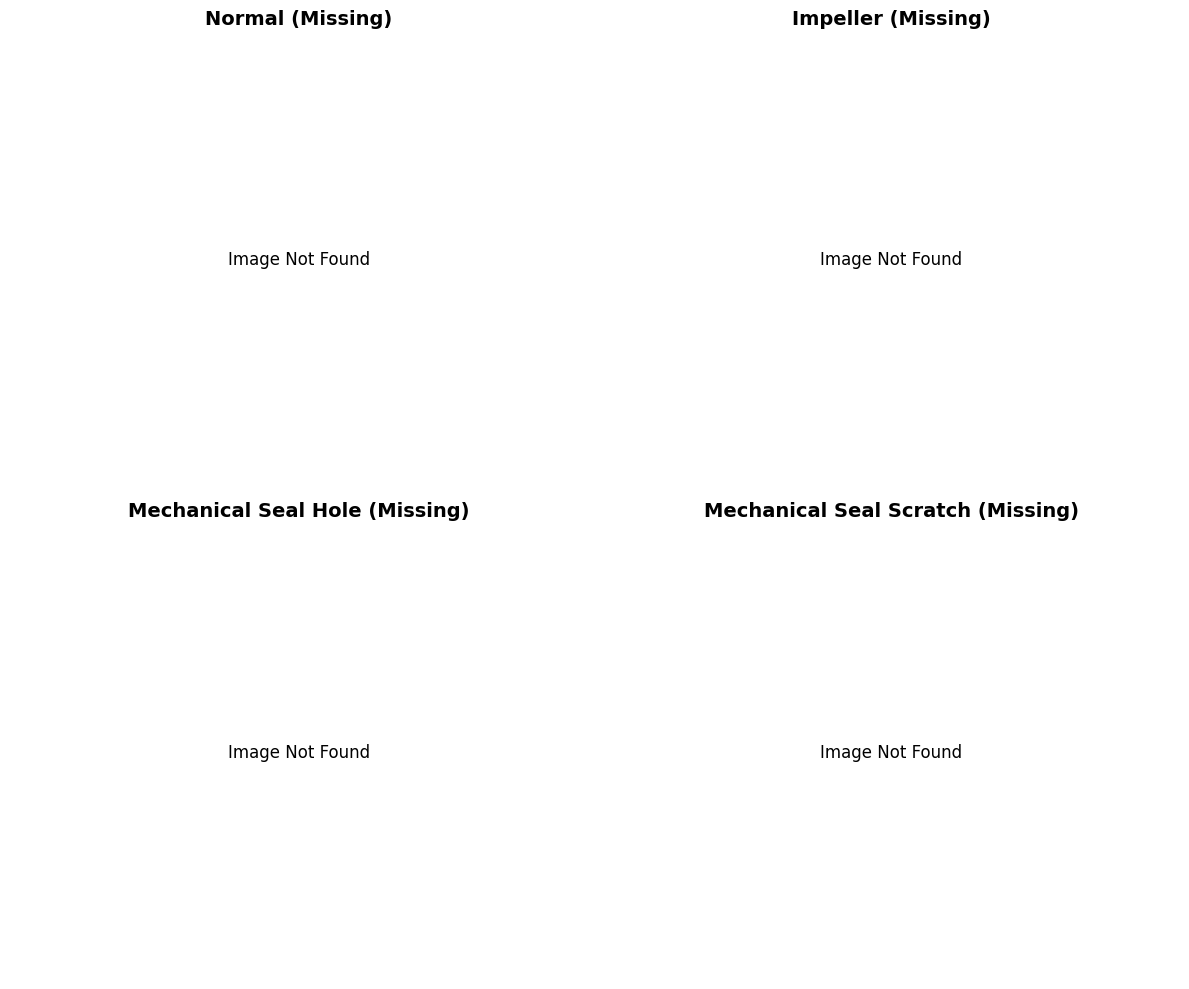

In [105]:
import matplotlib.pyplot as plt
import cv2
import os

# Define paths to your Grad-CAM++ images (update these as needed)
image_paths = {
    "Normal": "path/to/GradCAM_Normal.png",
    "Impeller": "path/to/GradCAM_Impeller.png",
    "Mechanical Seal Hole": "path/to/GradCAM_Mechanical_seal_Hole.png",
    "Mechanical Seal Scratch": "path/to/GradCAM_Mechanical_seal_Scratch.png"
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Load and plot each image
for ax, (label, path) in zip(axes, image_paths.items()):
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(label, fontsize=14, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'Image Not Found', ha='center', va='center', fontsize=12)
        ax.set_title(f"{label} (Missing)", fontsize=14, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.savefig("GradCAM_4_Class_Layout.png", dpi=1000, bbox_inches='tight')
plt.show()


In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Load Grad-CAM image ===
image_path = "GradCAM_Impeller_(3.0BAR).png"  # Replace with your actual path
img = cv2.imread(image_path)

# === Resize (Optional) for uniform appearance ===
img = cv2.resize(img, (224, 224))

# === Apply Gaussian Blur for smoother transitions (Optional) ===
blurred = cv2.GaussianBlur(img, (3, 3), 0)

# === Convert to float32 for manipulation ===
img_float = np.float32(blurred) / 255.0

# === Increase contrast and color intensity ===
alpha = 1.8  # Contrast control (>1 increases contrast)
beta = 0.2   # Brightness control
enhanced = np.clip(alpha * img_float + beta, 0, 1)

# === Convert back to uint8 for display ===
final_img = np.uint8(enhanced * 255)

# === Display ===
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Enhanced Grad-CAM - Impeller (3.0BAR)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("GradCAM_Impeller_Enhanced.png", dpi=1000)
plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [108]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
from PIL import Image

# === Grad-CAM++ Class ===
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self.save_activation))
        self.hook_handles.append(target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()
        target = output[:, class_idx]
        target.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

# === Load and Preprocess Image ===
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# === Overlay Heatmap on Image ===
def overlay_heatmap(img_tensor, heatmap, save_path):
    img = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000)  # High resolution
    plt.close()

# === Main Execution ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Select layer based on architecture (EfficientNet example)
target_layer = model.get_submodule("features.6")  # You may adjust to deeper layer if needed

# Dataset Details
class_names = [
    'Normal (3BAR)',
    'Impeller (3.0BAR)',
    'Mechanical seal Hole (3BAR)',
    'Mechanical seal Scratch (3.0BAR)'
]
scalogram_dir = r"E:\CP Dataset\cwt"  # Update path

gradcam = GradCAMPlusPlus(model, target_layer)

for class_name in class_names:
    class_folder = os.path.join(scalogram_dir, class_name)
    image_list = os.listdir(class_folder)

    if not image_list:
        print(f"❌ No images in: {class_folder}")
        continue

    image_path = os.path.join(class_folder, image_list[0])  # First image
    input_tensor = load_image(image_path).to(device)
    heatmap = gradcam.generate(input_tensor)
    cleaned_name = class_name.replace(" ", "_").replace("(", "").replace(")", "")
    overlay_heatmap(input_tensor.cpu(), heatmap, f"GradCAM_{cleaned_name}.png")
    print(f"✅ Saved Grad-CAM++ for {class_name}")


✅ Saved Grad-CAM++ for Normal (3BAR)
✅ Saved Grad-CAM++ for Impeller (3.0BAR)
✅ Saved Grad-CAM++ for Mechanical seal Hole (3BAR)
✅ Saved Grad-CAM++ for Mechanical seal Scratch (3.0BAR)


In [109]:
def overlay_heatmap_clahe(img_tensor, heatmap, save_path):
    img = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)

    # Apply CLAHE to the heatmap
    heatmap_255 = np.uint8(255 * heatmap)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    heatmap_eq = clahe.apply(heatmap_255)

    heatmap_color = cv2.applyColorMap(heatmap_eq, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000)
    plt.close()


In [110]:
def overlay_heatmap_enhanced(img_tensor, heatmap, save_path):
    img = img_tensor.squeeze().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)

    # Normalize and enhance heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Combine with original
    overlay = cv2.addWeighted(img, 0.5, heatmap_color, 0.5, 0)

    # Sharpen the final image (optional)
    kernel_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    overlay = cv2.filter2D(overlay, -1, kernel_sharp)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000)
    plt.close()


In [13]:
pip install grad-cam


     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     --------- ------------------------------ 1.8/7.8 MB 10.1 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.8 MB 11.0 MB/s eta 0:00:01
     ----------------------------------- ---- 6.8/7.8 MB 11.3 MB/s eta 0:00:01
     ---------------------------------------- 7.8/7.8 MB 10.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached ttach-0.0.3-py3-none-any.whl.metadata (5.2 kB)
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -- ------------------------------------- 2.4/39.5 MB 11.2 MB/s eta 0:00:04
   ----- ---------------------------------- 5.0/39.5 MB 11.6 MB/s eta 0:0

In [14]:
import torch
from torchvision import transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [15]:
target_layers = [model.features[-1]]


In [18]:
img_path = r"E:\CP Dataset\cwt\Normal (3BAR)\5.png"
image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0).to(device)


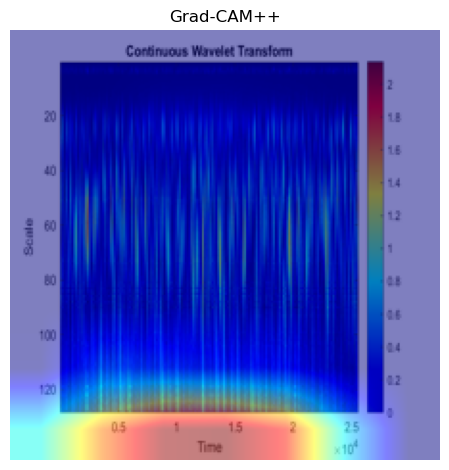

In [23]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. Put model in eval mode and move to device
model.eval()
model = model.to(device)

# 2. Choose target layer (EfficientNet-B0: use the last feature block)
target_layers = [model.features[-1]]

# 3. Load and preprocess image

image = Image.open(r"E:\CP Dataset\cwt\Normal (3BAR)\5.png").convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)
rgb_image = np.array(image.resize((224, 224))) / 255.0  # For overlay

# 4. Set target class (0 = Normal, 1 = Impeller, etc.)
targets = [ClassifierOutputTarget(0)]

# 5. Grad-CAM++ (use `with` block to prevent memory leak)
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# 6. Show result
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM++")
plt.tight_layout()

plt.show()


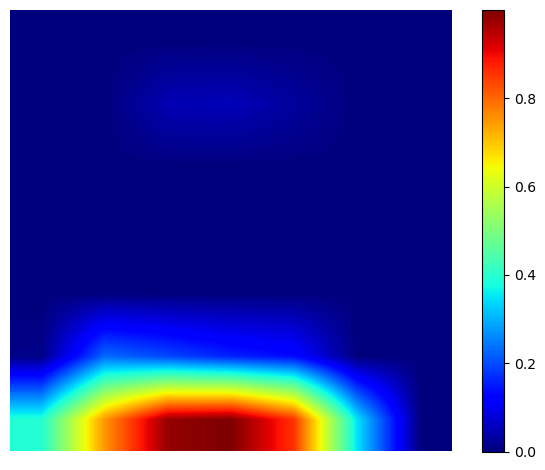

In [25]:
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # shape: (H, W)

# Show raw Grad-CAM++
plt.imshow(grayscale_cam, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()


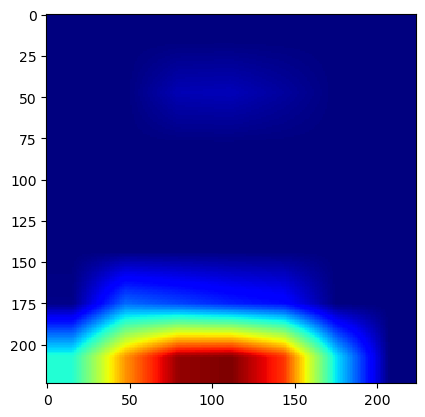

In [26]:
plt.imshow(grayscale_cam, cmap='jet', interpolation='nearest')  # no smoothing


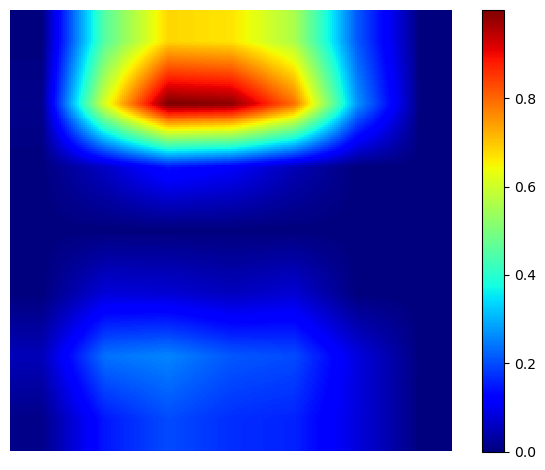

In [27]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation and move to correct device
model.eval()
model = model.to(device)

# Target layer for EfficientNet-B0
target_layers = [model.features[-1]]  # Adjust if you're using a custom model

# Load and preprocess the image
img_path = r"E:\CP Dataset\cwt\Mechanical seal Scratch (3.0BAR)\5.png"
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Target class index (change to match your label mapping)
targets = [ClassifierOutputTarget(3)]  # Assuming 3 = Mechanical seal Scratch

# Compute Grad-CAM++
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Show raw Grad-CAM++ (blocky/pixelated)
plt.imshow(grayscale_cam, cmap='jet', interpolation='nearest')

plt.axis('off')
plt.colorbar()
plt.tight_layout()

plt.show()
